In [ ]:
# Incase we have to clear all variables
%reset -f

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']

from dimer_setup import *
from utils import *

### Example Liouvillian

In [2]:
import time
from heatmap_setup import calculate_steadystate
import numpy as np


w_2 = 1.4*ev_to_inv_cm
bias = 0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 100./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)

H, L = get_H_and_L(PARAMS, silent=False, threshold=1e-7, site_basis=site_basis)



****************************************************************
The operators took 3.46627497673 and have dimension 64.
Building the RC Liouvillian took 3.644 seconds.
It is 4096by4096. The full basis would be 4096by4096
It took  2.03595709801  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 4.519% to 3.407%


In [5]:
ssL, info = calculate_steadystate(H, L, method="power", persistent=True)
exps = make_expectation_operators(H, PARAMS, site_basis=site_basis)

ss_therm = thermal_state(PARAMS["T_EM"], H[1])
for key, op in exps.items():
    if 'RC' not in key:
        if 'coherence' in key:
            res, therm = (ssL*op).tr(), (ss_therm*op).tr()
        else:
            res, therm = (ssL*op).tr().real, (ss_therm*op).tr().real
        print "{} : {} \t | \t {} \t | \t {}".format(key, res, therm, abs(res - therm))

Steady state took 0.107 seconds with power
OO : 0.879917917375 	 | 	 0.879917918568 	 | 	 1.19214638161e-09
sigma_y : 0.0 	 | 	 0.0 	 | 	 0.0
sigma_x : -0.00224802314735 	 | 	 -0.00224802182434 	 | 	 1.32301048459e-09
XO : 0.0575603194337 	 | 	 0.0575603191526 	 | 	 2.81099497845e-10
bright : 0.0568656420775 	 | 	 0.0568656422052 	 | 	 1.27733240651e-10
eig_coherence : (-1.97866896479e-18+0j) 	 | 	 (-5.20417042793e-18+0j) 	 | 	 3.22550146314e-18
dark : 0.0593790083637 	 | 	 0.0593790070122 	 | 	 1.35143744112e-09
XX : 0.00383743218343 	 | 	 0.00383743221499 	 | 	 3.15579957999e-11
OX : 0.0586843310074 	 | 	 0.0586843300648 	 | 	 9.42604723442e-10
site_coherence : (-0.00112401157367+0j) 	 | 	 (-0.00112401091217+0j) 	 | 	 6.61505242293e-10


In [ ]:
print_PARAMS(PARAMS)

###  Helper functions for generating solution estimates, manipulating operators and changing bases

In [ ]:
from scipy.sparse.linalg import eigs
from qutip.cy.spconvert import dense2D_to_fastcsr_fmode

def v0_estimate(H, PARAMS, method=0):
    H = H[1]
    T1, T2 = PARAMS['T_EM'], 0.5*(PARAMS['T_1']+PARAMS['T_2'])
    alpha1, alpha2 = PARAMS['alpha_EM'], 0.5*(PARAMS['alpha_1']+PARAMS['alpha_2'])
    p1 = alpha1/(alpha1+alpha2)
    p2 = alpha2/(alpha1+alpha2)
    p1/= (p1+p2)
    p2/= (p1+p2)
    if method==1:
        # Average two density matrices together
        r1 = (-beta_f(T1)*H).expm(method='sparse')
        r1/ = r1.tr()
        r2 = (-beta_f(T2)*H).expm(method='sparse')
        r2/ = r2.tr()
        rho_approx = r1#+r2
        return qt.operator_to_vector(rho_approx/rho_approx.tr()).data.todense()
    elif method==0:
        # Averages temperatures
        r1 = (-beta_f(abs(2*T1-T2))*H).expm(method='sparse')
        return qt.operator_to_vector(r1/r1.tr()).data.todense()
    else:
        r1 = (-beta_f(T1)*H).expm(method='sparse')
        r2 = (-beta_f(T2)*H).expm(method='sparse')
        rho_approx = 0.5*(r1+r2)+(-beta_f(abs(2*T1-T2))*H).expm(method='sparse')
        return qt.operator_to_vector(rho_approx/rho_approx.tr()).data.todense()

def expectation(rho, expval='site_coherence'):
    e_op = make_expectation_operators(PARAMS)[expval]
    return (rho*e_op).tr()

def vec_to_dm(evec, _H):
    n = int(np.sqrt(evec.shape[0]))
    data = dense2D_to_fastcsr_fmode(evec.reshape((n, n)).T, n, n)
    data = 0.5 * (data + data.H)
    data = qt.Qobj(data, dims=_H[1].dims, isherm=True)
    return data/data.tr()

def L_steadystate(L, tol=1e-8, sigma=1e-12, ncv=18, print_coh=True, v0=None):
    ti = time.time()
    evals, evec = eigs(L, 1, which='LM', sigma=sigma, tol=tol, ncv=ncv, v0=v0)
    print("Steadystate took {:0.3f} seconds".format(time.time() - ti))
    rho = vec_to_dm(evec, H)
    if print_coh:
        print("Coherence is {}".format(expectation(rho)))
    return rho

def _steadystate(H, L, tol=1e-8, sigma=1e-12, ncv=18, print_coh=True, v0=None):
    L_full = -1*qt.liouvillian(H[1], c_ops=[L]).data
    ti = time.time()
    evals, evec = eigs(L_full, 1, which='LM', sigma=sigma, tol=tol, ncv=ncv, v0=v0)
    print("Steadystate took {:0.3f} seconds".format(time.time() - ti))
    rho = vec_to_dm(evec, H)
    if print_coh:
        print("Coherence is {}".format(expectation(rho)))
    return rho

#ev, evec = H[1].
from scipy.linalg import eig, inv
import numpy as np

def sorted_eig(_H):
    if type(_H) == qt.Qobj:
        _H = _H.full()
    eigenValues, eigenVectors = eig(_H)
    idx = eigenValues.argsort()[::-1]   
    return eigenValues[idx], eigenVectors[:,idx]

def to_eigenbasis(op, evals, evecs, evecs_inv):
    if type(op) == qt.Qobj:
        op = op.full()
    A = np.matmul(evecs_inv, op)
    return np.matmul(A, evecs)

def to_site_basis(op, evals, evecs, evecs_inv):
    if type(op) == qt.Qobj:
        op = op.full()
    A = np.matmul(evecs, op)
    return np.matmul(A, evecs_inv)

def array_to_qobj(arr, qobj_in_basis):
    return qt.Qobj(arr, dims=qobj_in_basis.dims)

#print H[1]
eVals, eVecs = H[1].eigenstates()
evecs = np.transpose(np.array([v.dag().full()[0] for v in eVecs]))

#evals, evecs = sorted_eig(H[1])
ti = time.time()
evecs_inv = inv(evecs)
print (time.time() - ti)
D = to_eigenbasis(H[1], evals, evecs, evecs_inv)
H_again = to_site_basis(qt.Qobj(D), evals, evecs, evecs_inv)

assert np.sum(np.around(sorted_eig(qt.Qobj(H_array))[0]-sorted_eig(qt.Qobj(D))[0], 3)) == 0. # get diagonal
assert np.sum(np.around(H_again - H_array, 3)) == 0. # get H again from diagonal

print np.sum(D)
print np.sum(H[1].transform(eVecs).full())


v0 = v0_estimate(H, PARAMS, method=0)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0, method="eigen")

v0 = v0_estimate(H, PARAMS, method=1)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0)

v0 = v0_estimate(H, PARAMS, method=2)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0)

## Inspecting how sparsity and $\textit{chopping}$ affect structure and solution time

In [ ]:
H, L = get_H_and_L(PARAMS, silent=False, threshold=0, site_basis=site_basis)
ssL, infoL = calculate_steadystate(H, L, method="power", persistent=True)
H, L_tidy = get_H_and_L(PARAMS, silent=False, threshold=1e-7, site_basis=site_basis)
ssLt, infoLt = calculate_steadystate(H, L_tidy, method="power", persistent=True)

print "Total error per nz dm element due to chop: {}".format(np.sum((ssL.full()-ssLt.full())**2)/nonzero_elements(ssL)) 

visualise_dense(ssL)
visualise_dense(ssLt)

visualise_sparse(L)
visualise_sparse(L_tidy)


# Excitation restriction

In [ ]:
import heatmap_setup as hm
reload(hm)
x_values=[5,6,7,8] # N
y_values=[8,7,6,5] # exc_diff (exc = 2n-exc_diff)
method='direct'
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['N_1', 'N_2'],
                            y_axis_parameters=['exc_diff'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name='heatmap_excvN', save_data=True,
                            persistent=False, method=method, threshold=1e-7)

N_1 = 5, N_2 = 5, exc= 2, H_dim=24
Steady state took 0.043 seconds with direct
Build time: 1.315 	 | 	 Solution time: 0.043 	 | 	 Sigma x -0.057585317871
N_1 = 6, N_2 = 6, exc= 4, H_dim=60
Steady state took 0.473 seconds with direct
Build time: 3.558 	 | 	 Solution time: 0.473 	 | 	 Sigma x -0.056072230693


In [44]:
ss_obs_array = steadystate_observable(ss_array, PARAMS, 'sigma_x')
ss_obs_array[0]-ss_obs_array[-1]

array([ -1.37107951e-03,  -3.13628711e-04,  -6.99484716e-05,
        -1.46931791e-05])

plotting in new style
saved at PLOTS/heatmap_excvN_6.pdf


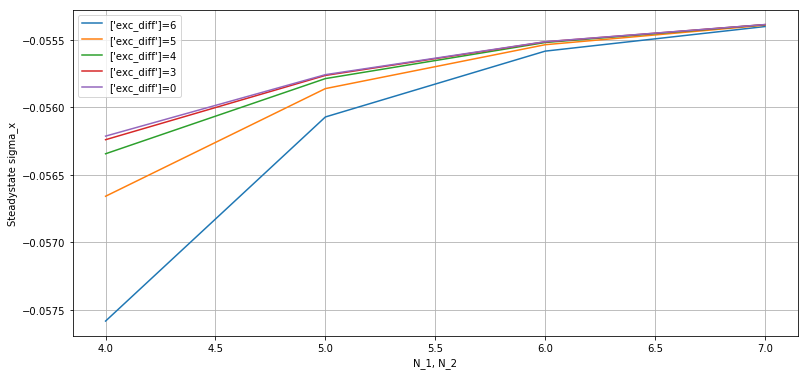

In [29]:
heatmap_plotter(num=6, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x', reverse_x=False)

plotting in new style
saved at PLOTS/heatmap_excvN_5.pdf


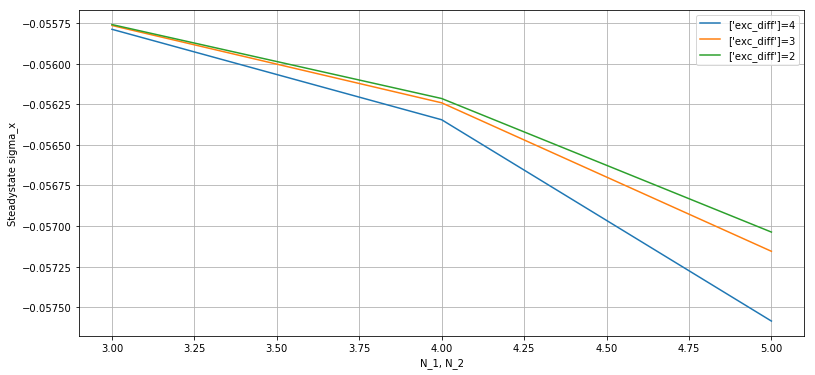

In [20]:
ss_info_params = [ss_array, info_array, PARAMS]

#heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
#                print_params=False, observable='sigma_x', reverse_x=True)
heatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x', reverse_x=False)

In [11]:
PARAMS['y_values']

[4, 3, 2]

In [11]:
def steadystate_observable(ss_array, PARAMS, observable):
    try:
        size = (len(PARAMS['y_values']), len(PARAMS['x_values']))
    except KeyError:
        size = (1,1)
    # deal with the case where N is being changed as an x value
    if 'N_1' in PARAMS['x_axis_parameters']:
        data_array = np.zeros(size)         # Collect data
        N_values = PARAMS['x_values']
        # NEw observable operator for each N value
        for i, N in enumerate(N_values):
            PARAMS.update({'N_1' : N, 'N_2' : N})
            exc = 2*N-PARAMS['exc_diff']
            # Leave it so exc can be fixed or a y_parameter
            if 'exc' in PARAMS['x_axis_parameters']:
                PARAMS.update({'exc': exc})
            _obs_op = make_expectation_operators(PARAMS)[observable]
            for j, y in enumerate(PARAMS['y_values']):
                # the case where exc is on the y axis
                if 'exc_diff' in PARAMS['y_axis_parameters']:
                    PARAMS.update({'exc': 2*N-y})
                    _obs_op = make_expectation_operators(PARAMS)[observable]
                try:
                    #print j,i ,ss_array[j][i].shape, _obs_op.shape
                    data_array[j][i] = (qt.Qobj(ss_array[j][i])*_obs_op).tr().real
                except AttributeError:
                    data_array[j][i] = np.nan
        return data_array
    else:
        # Much simpler if N isn't on the x-axis
        obs_op = make_expectation_operators(PARAMS)[observable]
        f = lambda x: (qt.Qobj(x)*obs_op).tr()
        ss_array = np.reshape(ss_array, (1, size[0]*size[1]))[0]

        data_array = map(f, ss_array)
        data_array = np.array(data_array).reshape(size).real
        return data_array



0 0 (88, 88) (88, 88)
1 0 (96, 96) (96, 96)
2 0 (100, 100) (100, 100)
3 0 (100, 100) (100, 100)
0 1 (52, 52) (52, 52)
1 1 (60, 60) (60, 60)
2 1 (64, 64) (64, 64)
3 1 (64, 64) (64, 64)
0 2 (24, 24) (24, 24)
1 2 (32, 32) (32, 32)
2 2 (36, 36) (36, 36)
3 2 (36, 36) (36, 36)


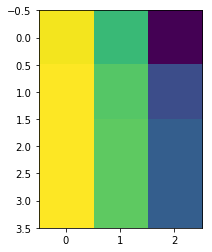

In [33]:
plt.imshow(steadystate_observable(ss_array, PARAMS, 'sigma_x'))

In [23]:
# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array

def heatmap_plotter(ss_info_params=False, num=-1, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True):
    if num>=0:
        ss_array, PARAMS, info_array = heatmap_loader(num, dir_name=dir_name)
        
    if ss_info_params:
        if num>=0:
            print "Not loading saved data, using data from arguments instead"
        ss_array,info_array, PARAMS = ss_info_params[0], ss_info_params[1], ss_info_params[2]
    info = info_array[0][0]
    #print info
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "plotting in new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    #print PARAMS
    ss_array = steadystate_observable(ss_array, PARAMS, observable)
    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']
        #x_values = x_values[::-1]
        #if reverse_x: # Crazy bug which flips x direction - cba to refactor
        #    x_values = x_values[::-1]
        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    if print_params:
        print_PARAMS(PARAMS)
    
    plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

plotting in new style
saved at PLOTS/heatmap_-1.pdf


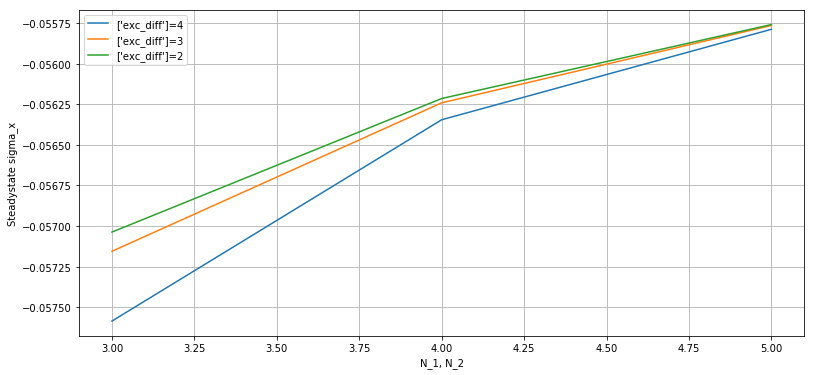

In [24]:
ss_info_params = [ss_array, info_array, PARAMS]

heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
                print_params=False, observable='sigma_x', reverse_x=False)

# For N=6, with no 

In [ ]:
"""from heatmap_setup import steadystate

w_2 = 8000.
alpha = 20.

N = 6
pap = alpha_to_pialpha_prop(alpha, w_2)
PARAMS = PARAMS_setup(bias=100., w_2=8000., V = 100., pialpha_prop=pap,
                                 T_EM=6000., T_ph =300.,
                                 alpha_EM=0.1, shift=True,
                                 num_cpus=3, N=N, Gamma=200., w_0=300.,
                                 silent=True, exc_diff=0)
from numpy.linalg import norm
def estimateCondition(M):
    vec = np.ones((1, M.shape[0])).T
    return norm(M.dot(vec), np.inf)"""

# Comparing SS solution methods (direct, inverse power, eigen)

****************************************************************
The operators took 1.05348801613 and have dimension 36.
Building the RC Liouvillian took 1.084 seconds.
It is 1296by1296. The full basis would be 1296by1296
It took  0.612405061722  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 7.761% to 5.761%
Steady state took 0.053 seconds with direct
****************************************************************
The operators took 2.11585402489 and have dimension 64.
Building the RC Liouvillian took 2.226 seconds.
It is 4096by4096. The full basis would be 4096by4096
It took  1.81966614723  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 4.519% to 3.407%
Steady state took 1.234 seconds with direct
****************************************************************
The operators took 12.5072419643 and have dimension 100.
Building the RC Liouvillian took 13.308 seconds.
It is 10000by10000. The full basis would be 10

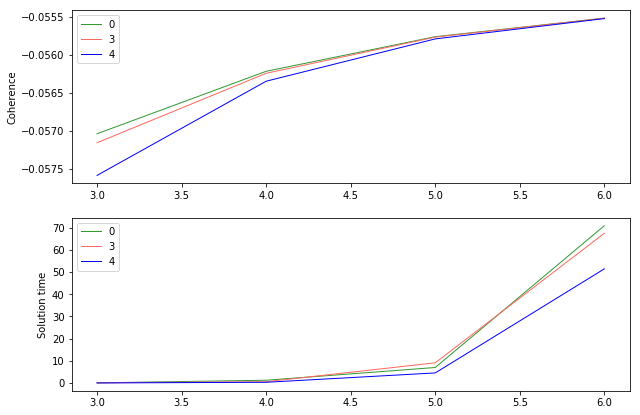

In [7]:
from qutip import build_preconditioner

def method_plotter(N_vals, data_dict, info_dict, ax1, ax2, linestyle="solid"):
    lw=1.
    if linestyle == 'dashed':
        lw=1.8
    for i, key in enumerate(data_dict.keys()):
        ax1.plot(N_vals, data_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
        #print info_dict[key]
        ax2.plot(N_vals, info_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
    ax1.legend()
    ax2.legend()
    ax1.set_ylabel("Coherence")
    ax2.set_ylabel("Solution time")


def method_comparison(N_i, N_f, plot=False, site_basis=True):
    methods = ['direct']
    data_dict = dict()
    info_dict = dict()
    N_vals = range(N_i, N_f)
    for exc_diff in [0,3,4]:
        for N in N_vals:
            PARAMS.update({'N_1':N, 'N_2':N, 'exc':int(2*N-exc_diff)})
            H, L = get_H_and_L(PARAMS,silent=False, threshold=1e-7, site_basis=site_basis)
            exps = make_expectation_operators(PARAMS, site_basis=site_basis)
            for method in methods:
                try:
                    M=None

                    if "iterative" in method:
                        ti = time.time()
                        M = build_preconditioner(H[1], [L], use_rcm=True, ILU_MILU='smilu_2')
                        print("Building preconditioner took {} seconds".format(time.time()-ti))
                    ss, full_info = calculate_steadystate(H, L, method=method, persistent=True)
                    info = full_info['solution_time']

                    coh = (exps['sigma_x']*ss).tr().real
                    try:
                        data_dict[exc_diff].append(coh)
                        info_dict[exc_diff].append(info)
                    except KeyError:
                        data_dict[exc_diff] = [coh]
                        info_dict[exc_diff] = [info]
                except Exception as err:
                    print( "{} failed due to : {}".format(method, err))
                    try:
                        data_dict[exc_diff].append(None)
                        info_dict[exc_diff].append(None)
                    except KeyError:
                        data_dict[exc_diff] = [None]
                        info_dict[exc_diff] = [None]
    #if plot:
    #    method_plotter(N_vals, data_dict, info_dict)
    return N_vals, data_dict, info_dict

N_vals, data_dict_sb, info_dict_sb = method_comparison(3,7)
#N_vals, data_dict_eb, info_dict_eb = method_comparison(3,7, site_basis=False)

f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
method_plotter(N_vals, data_dict_sb, info_dict_sb, ax1, ax2)
#method_plotter(N_vals, data_dict_eb, info_dict_eb, ax1, ax2, linestyle="dashed")


# Plotting methods

In [ ]:
heatmap_plotter(2, plot_SD=False, dir_name='heatmap_excvN', 
                     print_params=False, observable='', 
                    reverse_x=True)